In [1]:
from skimage import io

import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import os
import re
from datetime import datetime

In [2]:
def get_path(date):
    '''Get the path to experimental data. Note 
    that date needs to be a datetime object.'''
    date_str = date.strftime('%Y-%m-%d')
    return './' + date_str + '/'

In [3]:
def get_images(pict_list, pict_bw_list, filepath):
    '''Return dictionaries of images and bw images.'''
    image_dict = {}
    image_bw_dict = {}
    
    # Retrieve images
    for i, pict in enumerate(pict_list):
        image = io.imread(filepath + pict)
        image_dict[i] = image
    # Retrieve bw images
    for i, pict_bw in enumerate(pict_bw_list):
        image_bw = io.imread(filepath + pict_bw)
        image_bw_dict[i] = image_bw
        
    return image_dict, image_bw_dict

In [4]:
# Date of the experiment and filepath to the images taken
exp_date = datetime(2023, 1, 17)
path = get_path(exp_date)

In [5]:
# Locations of centers of all sites
sites_df = pd.read_csv(path + 'sites.csv')

In [6]:
# List all of the files in the directory
files = os.listdir(path)

# Get sorted lists of images and bw images
pict = []
pict_bw = []
for file in files:
    m = re.search('.png', file)
    m_bw = re.search('bw.png', file)
    if m_bw is not None:
        pict_bw.append(file)
    if m is not None and m_bw is None:
        pict.append(file)
pict.sort()
pict_bw.sort()

In [7]:
image_dict, image_bw_dict = get_images(pict, pict_bw, path)

In [8]:
occupied_mat = np.zeros((len(image_bw_dict), len(sites_df)), dtype='int')
for num, image_bw in image_bw_dict.items():
    for i in range(len(sites_df)):
        x = sites_df.iloc[i]['x']
        y = sites_df.iloc[i]['y']
        # Decide that the site is occupied or not
        # Note that the x's correspond to columns of the matrix !
        # and the y's correspond to rows of the matrix !
        if np.mean(image_bw[y-6:y+6, x-6:x+6]) < 150:
            occupied_mat[num, i] = 1

In [9]:
# The numbers of particles are not conserved
# When particles are between two sites, they are not detected
num_particles = np.sum(occupied_mat == 1, axis=1)
num_particles

array([75, 73, 74, 74, 74, 74, 74, 75, 74, 75, 75, 75, 75, 75, 75])

In [10]:
with np.printoptions(threshold=np.inf):
    print(occupied_mat[1:, :] - occupied_mat[:-1, :])

[[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  -1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0 -1  1  0 -1  1  0  0  0  0  0  0  0  0  0
   0 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 -1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 -1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

In [11]:
def detect_current(occupation_mat):
    '''Detect the current flow in the system.'''
    # Take the difference among successive frames
    diff_mat = occupation_mat[1:, :] - occupation_mat[:-1, :]
    
    # Quantities of our interest
    current = np.zeros(diff_mat.shape[0])
    time = diff_mat.shape[0]
    size = diff_mat.shape[1]
    
    for i in range(time):
        for j in range(size):
            # Exclude jumps of more than two steps (These jump rarely happen.)
            # Be careful with the periodic coundary conditions!
            
            # Not at the boundary
            if j != size - 1 and j != size - 2:
                if diff_mat[i, j] == -1 and diff_mat[i, j+1] == 1:
                    current[i] += 1
                elif diff_mat[i, j] == -1 and diff_mat[i, j+2] == 1:
                    current[i] += 2
                elif diff_mat[i, j] == 1 and diff_mat[i, j+1] == -1:
                    current[i] -= 1
                elif diff_mat[i, j] == 1 and diff_mat[i, j+2] == -1:
                    current[i] -= 2
            # At the boundary
            elif j == size - 1:
                if diff_mat[i, j] == -1 and diff_mat[i, 0] == 1:
                    current[i] += 1
                elif diff_mat[i, j] == -1 and diff_mat[i, 1] == 1:
                    current[i] += 2
                elif diff_mat[i, j] == 1 and diff_mat[i, 0] == -1:
                    current[i] -= 1
                elif diff_mat[i, j] == 1 and diff_mat[i, 1] == -1:
                    current[i] -= 2
            # At the boundary
            else:
                if diff_mat[i, j] == -1 and diff_mat[i, -1] == 1:
                    current[i] += 1
                elif diff_mat[i, j] == -1 and diff_mat[i, 0] == 1:
                    current[i] += 2
                elif diff_mat[i, j] == 1 and diff_mat[i, -1] == -1:
                    current[i] -= 1
                elif diff_mat[i, j] == 1 and diff_mat[i, 0] == -1:
                    current[i] -= 2
                    
    return current

In [12]:
current_arr = detect_current(occupied_mat)
current_arr

array([1., 0., 2., 0., 7., 1., 4., 0., 2., 0., 0., 0., 0., 0.])

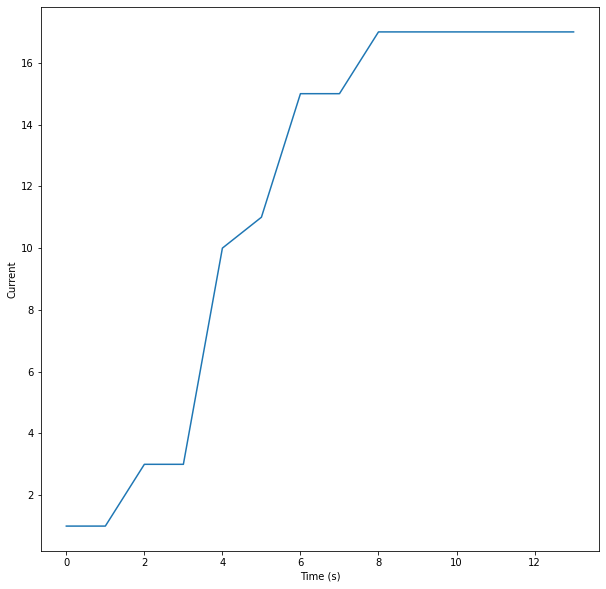

In [13]:
cumulative_current = np.cumsum(current_arr)
plt.figure(figsize=(10, 10))
plt.plot(cumulative_current)
plt.xlabel('Time (s)')
plt.ylabel('Current')
plt.show()

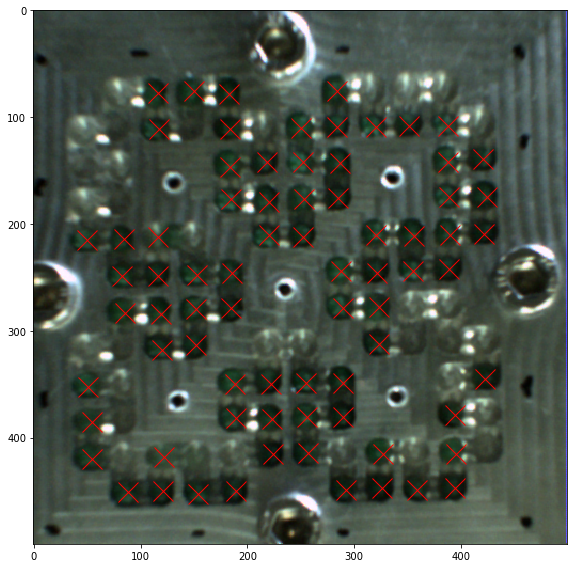

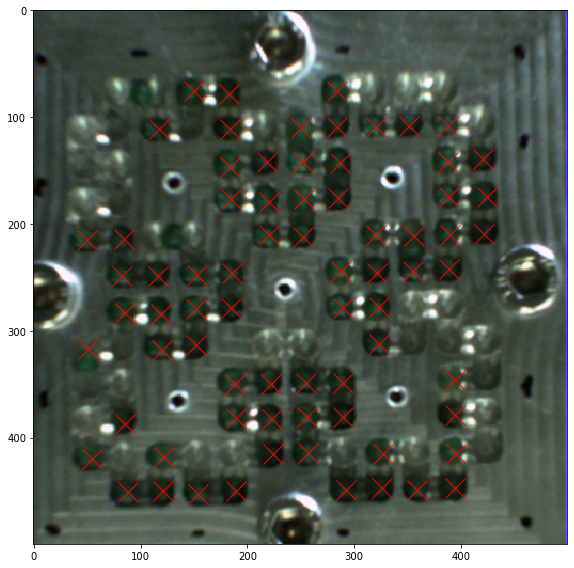

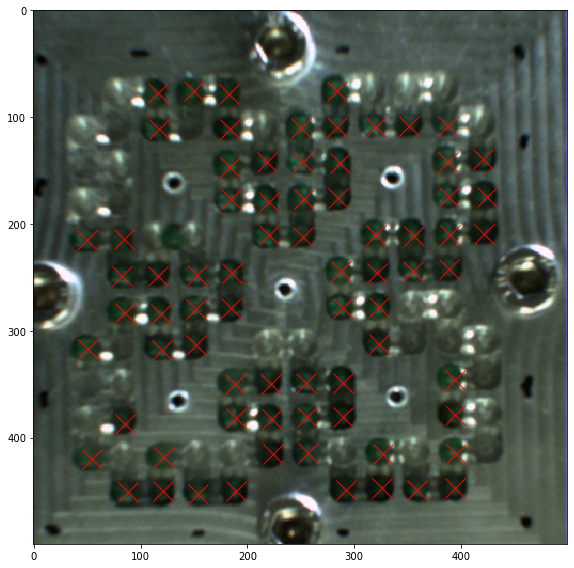

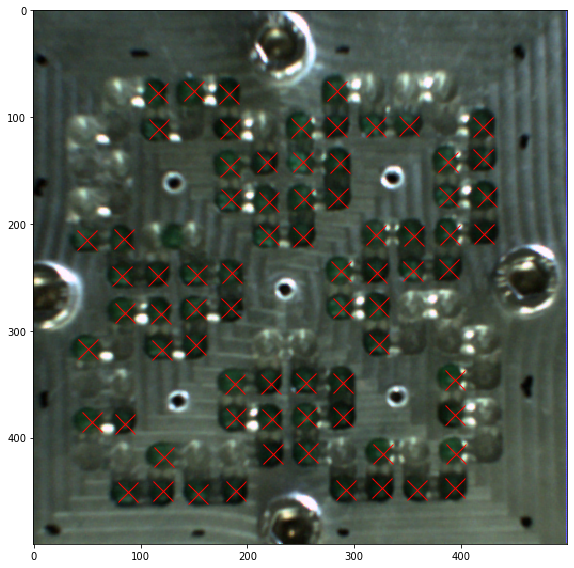

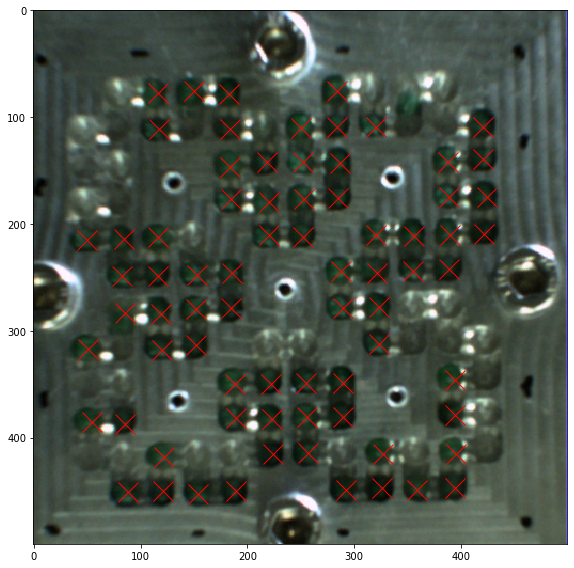

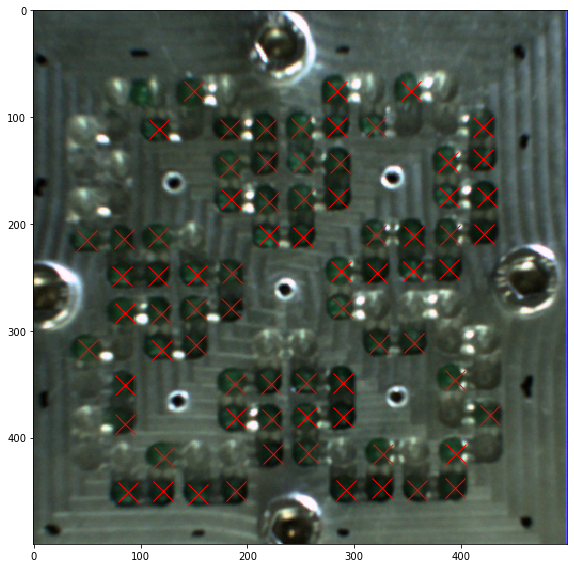

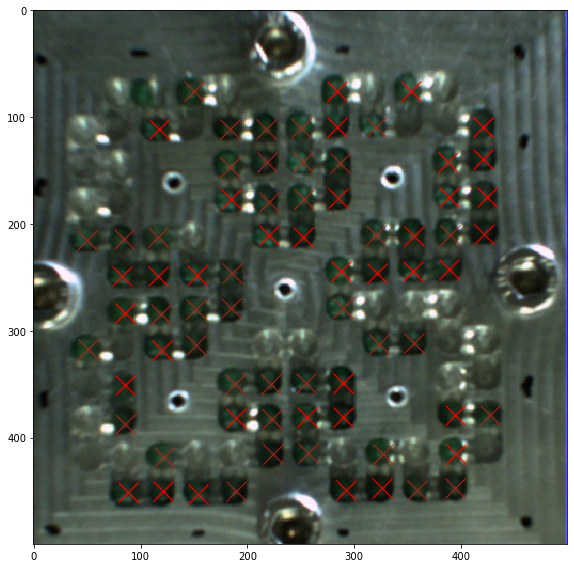

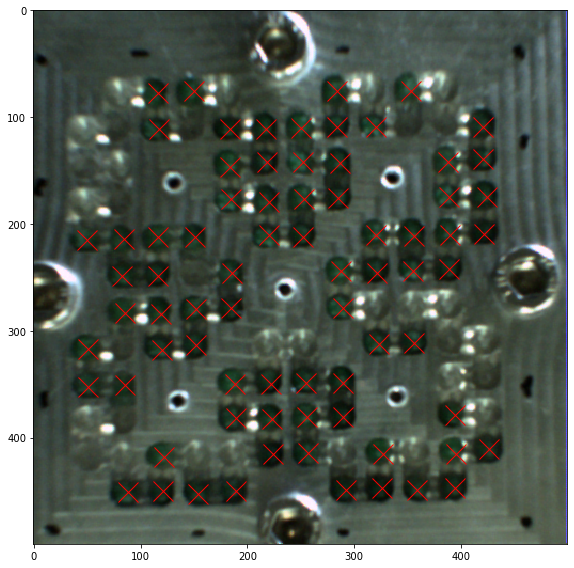

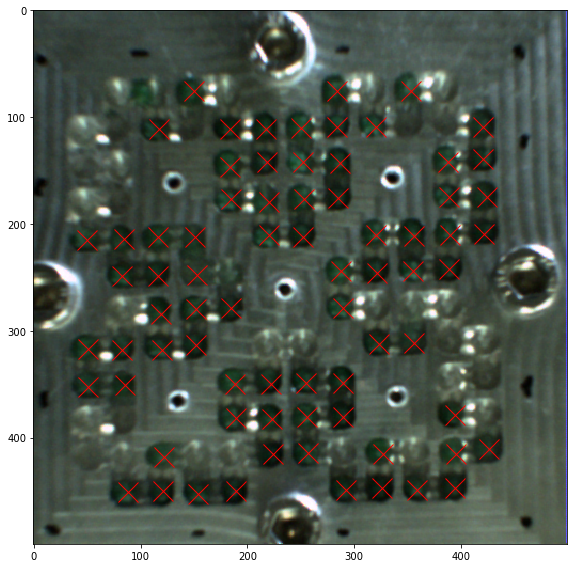

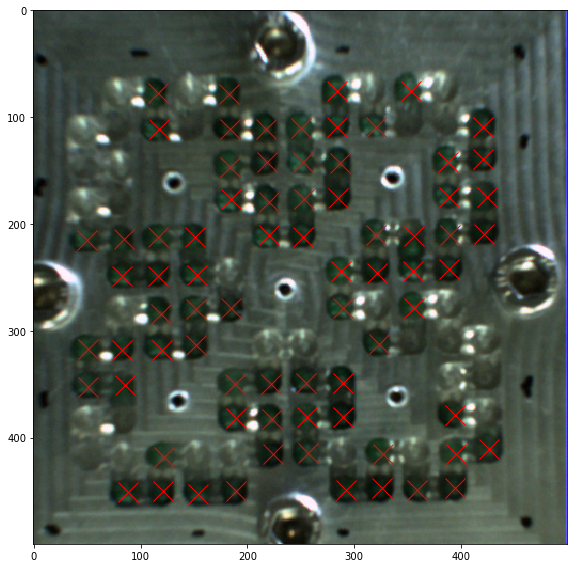

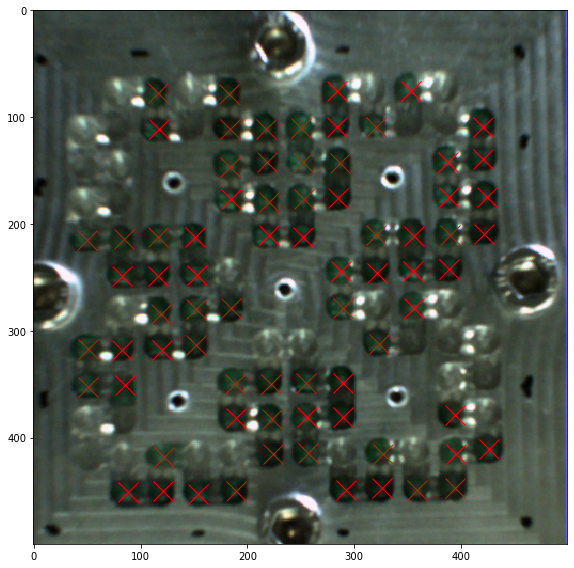

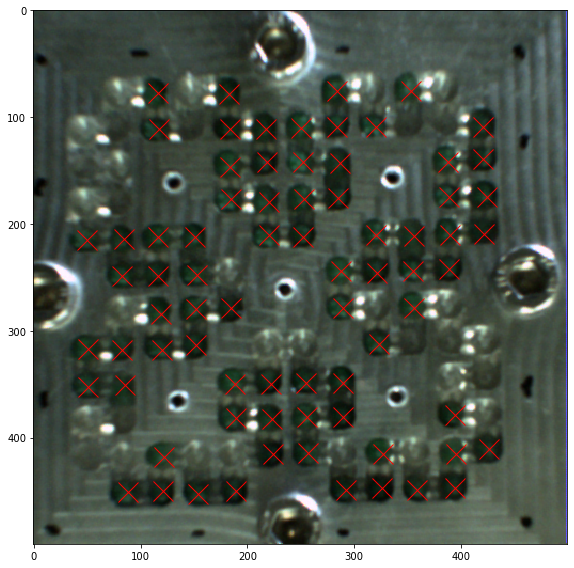

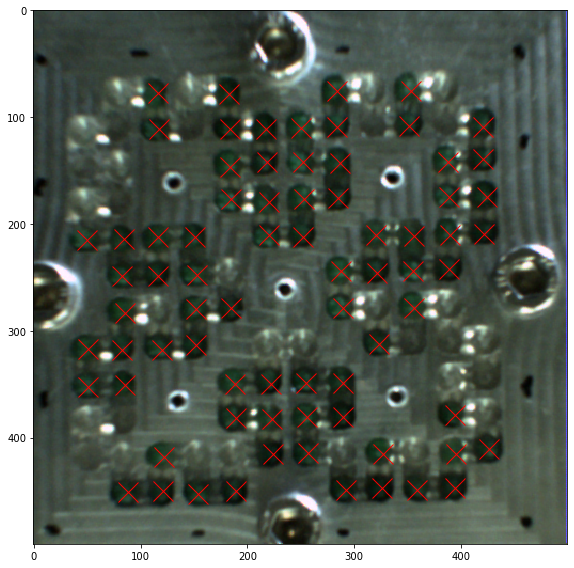

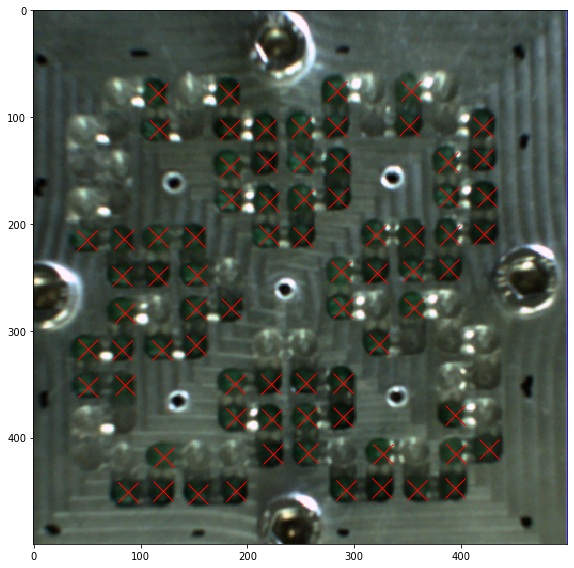

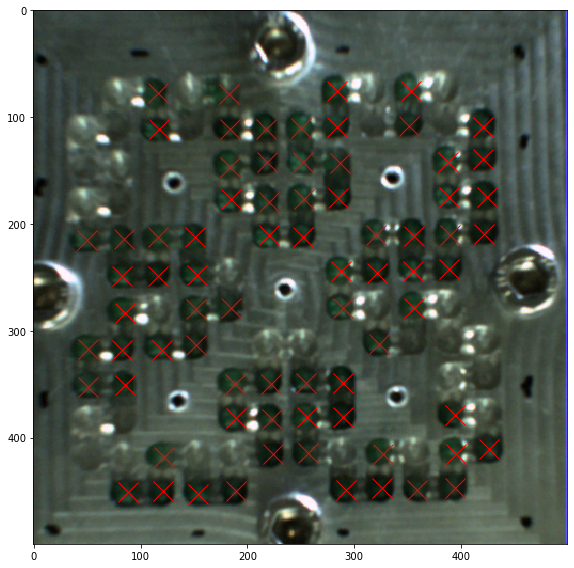

In [18]:
# Test if image analysis works well on images
for i in range(occupied_mat.shape[0]):
    image = image_dict[i]
    plt.figure(figsize=(8, 8))
    io.imshow(image)

    for j in range(len(sites_df)):
        x = sites_df.iloc[j]['x']
        y = sites_df.iloc[j]['y']
        occupied_flag = occupied_mat[i, j]
        if occupied_flag == 1:
            plt.plot(x, y, 'rx', markersize=20)
    plt.show()